Christopher Rudolph - 45241805 - MQ University

### to do: 
- **Challenge Q**: LR, is it possible to use the model such that if I give it a desired finish time, it outputs certain goals we must reach throughout the race? For example: We want to beat the original race time by 10 seconds. Where can be improved to achieve this? 

- **read me** 

# Analysis of Cycling Data


We are provided with four files containing recordings of cycling activities that include GPS location data as
well as some measurements related to cycling performace like heart rate and power.  The goal is to perform
some exploration and analysis of this data. 

The data represents four races.  Two are time trials where the rider rides alone on a set course.  Two are 
road races where the rider rides with a peleton.  All were held on the same course but the road races include
two laps where the time trials include just one. 

Questions to explore with the data:
* What is the overall distance travelled for each of the rides? What are the average speeds etc.  Provide a summary for each ride.
* Compare the range of speeds for each ride, are time trials faster than road races? 
* Compare the speeds achieved in the two time trials (three years apart).  As well as looking at the averages, can you see where in the ride one or the other is faster.  
* From the elevation_gain field you can see whether the rider is _climbing_ , _descending_ or on the _flat_.   Use this to calculate the average speeds in those three cases (climbing, flat or descending).  Note that _flat_ might not be zero elevation_gain but might allow for slight climbs and falls. 

### Notes: these questions above are usually asked by a demand expert (lecture w4)

For time varying data like this it is often useful to _smooth_ the data using eg. a [rolling mean](https://pandas.pydata.org/pandas-docs/version/0.17.0/generated/pandas.rolling_mean.html).  You might want to experiment with smoothing in some of your analysis (not required but may be of interest).

# Description of Fields

* **index** is a datetime showing the time that the observation was made (I wasn't riding at night, this is converted to UTC)
* __latitude, longitude, elevation__ from the GPS, the position of the rider at each timepoint, elevation in m
* __temperature__ the current ambient temperature in degrees celcius
* __power__ the power being generated by the rider in Watts
* __cadence__ the rotational speed of the pedals in revolutions per minute
* __hr__ heart rate in beats per minute
* __elevation_gain__ the change in elevation in m between two observations
* __distance__ distance travelled between observations in km
* __speed__ speed measured in km/h

You are provided with code in [gpxutils.py](gpxutils.py) to read the GPX XML format files that are exported by cycling computers and applications.  The sample files were exported from [Strava](https://strava.com/) and represent four races by Steve Cassidy.


# Setting up the DF

In [178]:
import gpxpy
import gpxpy.gpx
from gpxutils import parse_gpx 

import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
%matplotlib inline

In [179]:
from sklearn.model_selection import train_test_split
from sklearn import linear_model
from sklearn.metrics import r2_score
import seaborn as sns


In [180]:
# read the four data files
rr16 = parse_gpx('files/Calga_RR_2016.gpx')
tt16 = parse_gpx('files/Calga_TT_2016.gpx')
rr19 = parse_gpx('files/Calga_RR_2019.gpx')
tt19 = parse_gpx('files/Calga_TT_2019.gpx')

In [181]:
rr16.describe()

,latitude,longitude,elevation,temperature,power,cadence,hr,distance,elevation_gain,speed,timedelta
count,2822.000000,2822.000000,2822.000000,2822.000000,2822.0,2822.000000,2822.000000,2822.000000,2822.000000,2822.000000,2821.000000
mean,-33.368017,151.225527,232.404465,25.280652,0.0,65.987952,158.394401,0.017381,-0.003756,34.933085,1.843318
std,0.028329,0.006014,29.725934,1.348746,0.0,34.425881,11.304588,0.015695,0.458872,10.738677,1.692364
min,-33.416753,151.211496,176.000000,24.000000,0.0,0.000000,102.000000,0.000000,-1.600000,0.000000,1.000000
25%,-33.393691,151.221912,209.450000,24.000000,0.0,68.000000,151.000000,0.007894,-0.400000,26.656312,1.000000
50%,-33.371820,151.227236,226.100000,25.000000,0.0,79.000000,158.000000,0.011794,0.000000,33.307339,1.000000
75%,-33.342269,151.230069,258.200000,26.000000,0.0,87.000000,166.000000,0.016899,0.400000,42.871885,2.000000
max,-33.316890,151.235131,295.800000,30.000000,0.0,117.000000,205.000000,0.076283,1.200000,92.749036,9.000000


Checking the shapes to confirm they are of large sizes. We don't want to scroll through a large dataset, will have to use code access the dataset if I face any issues.

In [182]:
print(rr16.shape, tt16.shape, rr19.shape, tt19.shape)

(2822, 11) (1541, 11) (5503, 11) (2655, 11)


# Question 1:
What is the overall distance travelled for each of the rides? What are the average speeds etc.  Provide a summary for each ride.

`describe()` tells us a lot about all variables, but if we just want one variable at a time we can use specific functions like `sum()`.

In [183]:
rr16['distance'].sum()

49.04858574628638

The distance columns represents the total distance travelled after each checkpoint / observation. They are generally 1 seconds apart, though this varies. We can check the unique number of observation times with the timedelta column. So the 2016 road race has some observations that are 1 second apart, 2 seconds, 3 seconds and so on. 

In [184]:
set(rr16['timedelta'])

{nan, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0}

Using `sum()` will tell us how far the cyclist travelle, adding all the distances between each observation.

In [185]:
print(f"Total distance travelled for the 2016 road racer is {rr16['distance'].sum():.4} Km")

Total distance travelled for the 2016 road racer is 49.05 Km


We can confirm the above by noting the timestamps at the start and end of the race and multiplying it by the speed of the rider. Using simple formulae: 

$$\text{Total distance = speed}\times\text{time}$$
$$\text{km = km/hr}\times\text{hr}$$

In [186]:
time = 5*60*60 + 29*60 + 21 - 4*60*60 + 2*60 + 41 # converting the time taken to seconds then taking the difference between
# the start and end time 

speed = rr16['speed'].mean() /(60*60) #converting the mean speed to Km/s

(time * speed)

53.58347056004676

The result is similar, differences may be attributed to the fact we used a mean speed. The result of 49.05Km has a varying speed included. At each observation, there is a distance measured and a speed measured. So the sum of distance is a better measurement than using the mean speed and the time taken to complete the race. 

The following is a summary for what we will find for the races.
<ul>
    <li> the heart rate mean and max (no min because min will be before the race commences) </li>
    <li> temperature mean and max (no min because min will be before the race commences) </li>
    <li> speed mean and max </li>
    <li> time taken to complete the race </li>
    <li> total distance travelled </li>
    <li> mean and max cadence</li>
    <li> mean and max power </li>
    
</ul>

In [187]:
print(f"The mean heart rate for the road racer in 2016 is {rr16['hr'].mean()} bpm")

The mean heart rate for the road racer in 2016 is 158.39440113394755 bpm


In [188]:
print(f"The max heart rate for the road racer in 2016 is {rr16['hr'].max()} bpm")

The max heart rate for the road racer in 2016 is 205.0 bpm


In [189]:
print(f"The mean temperature for the road racer in 2016 is {rr16['temperature'].mean()} degrees Celcius")

The mean temperature for the road racer in 2016 is 25.280652019844084 degrees Celcius


In [190]:
print(f"The max temperature for the road racer in 2016 is {rr16['temperature'].max()} degrees Celcius") 

The max temperature for the road racer in 2016 is 30.0 degrees Celcius


In [191]:
print(f"The mean speed for the road racer in 2016 is {rr16['speed'].mean()} Km/hr")

The mean speed for the road racer in 2016 is 34.93308475482947 Km/hr


In [192]:
print(f"The max speed for the road racer in 2016 is {rr16['speed'].max()} Km/hr")

The max speed for the road racer in 2016 is 92.74903649913952 Km/hr


In [193]:
print(f"The time taken for the road racer in 2016 is {rr16['distance'].sum() / rr16['speed'].mean()} hours")

The time taken for the road racer in 2016 is 1.404072560168207 hours


In [194]:
print(f"The total distance travelled for the road racer in 2016 is { rr16['distance'].sum() } Km")

The total distance travelled for the road racer in 2016 is 49.04858574628638 Km


In [195]:
print(f"The mean cadence for the road racer in 2016 is {rr16['cadence'].mean() } rpm")

The mean cadence for the road racer in 2016 is 65.98795180722891 rpm


In [196]:
print(f"The max cadence for the road racer in 2016 is {rr16['cadence'].max() } rpm")

The max cadence for the road racer in 2016 is 117.0 rpm


In [197]:
print(f"The power produced by the road racer in 2016 is null in the DF. This column should be dropped")

The power produced by the road racer in 2016 is null in the DF. This column should be dropped


As we can see, this is a very tedious task. This would work best in a function

In [198]:
def summaryFn(myDF, raceTypeString, yearString):
    
    print(f"The mean heart rate for the {raceTypeString} racer in {yearString} is {myDF['hr'].mean():.4} bpm")
    print(" ")
    print(f"The max heart rate for the {raceTypeString} racer in {yearString} is {myDF['hr'].max():.4} bpm")
    print(" ")
    print(f"The mean temperature for the {raceTypeString} racer in {yearString} is {myDF['temperature'].mean():.4} degrees Celcius")
    print(" ")
    print(f"The max temperature for the {raceTypeString} racer in {yearString} is {myDF['temperature'].max():.4} degrees Celcius") 
    print(" ")
    print(f"The mean speed for the {raceTypeString} racer in {yearString} is {myDF['speed'].mean():.4} Km/hr")
    print(" ")
    print(f"The max speed for the {raceTypeString} racer in {yearString} is {myDF['speed'].max():.4} Km/hr")
    print(" ")
    print(f"The time taken for the {raceTypeString} racer in {yearString} is {myDF['distance'].sum() / myDF['speed'].mean():.4} hours")
    print(" ")
    print(f"The total distance travelled for the {raceTypeString} racer in {yearString} is { myDF['distance'].sum():.4} Km")
    print(" ")
    print(f"The mean cadence for the {raceTypeString} racer in {yearString} is {myDF['cadence'].mean():.4} rpm")
    print(" ")
    print(f"The max cadence for the {raceTypeString} racer in {yearString} is {myDF['cadence'].max():.4} rpm")

In [199]:
summaryFn(rr16, 'road', '2016')

The mean heart rate for the road racer in 2016 is 158.4 bpm
 
The max heart rate for the road racer in 2016 is 205.0 bpm
 
The mean temperature for the road racer in 2016 is 25.28 degrees Celcius
 
The max temperature for the road racer in 2016 is 30.0 degrees Celcius
 
The mean speed for the road racer in 2016 is 34.93 Km/hr
 
The max speed for the road racer in 2016 is 92.75 Km/hr
 
The time taken for the road racer in 2016 is 1.404 hours
 
The total distance travelled for the road racer in 2016 is 49.05 Km
 
The mean cadence for the road racer in 2016 is 65.99 rpm
 
The max cadence for the road racer in 2016 is 117.0 rpm


In [200]:
summaryFn(rr16, 'road', '2016')

The mean heart rate for the road racer in 2016 is 158.4 bpm
 
The max heart rate for the road racer in 2016 is 205.0 bpm
 
The mean temperature for the road racer in 2016 is 25.28 degrees Celcius
 
The max temperature for the road racer in 2016 is 30.0 degrees Celcius
 
The mean speed for the road racer in 2016 is 34.93 Km/hr
 
The max speed for the road racer in 2016 is 92.75 Km/hr
 
The time taken for the road racer in 2016 is 1.404 hours
 
The total distance travelled for the road racer in 2016 is 49.05 Km
 
The mean cadence for the road racer in 2016 is 65.99 rpm
 
The max cadence for the road racer in 2016 is 117.0 rpm


In [201]:
summaryFn(tt16, 'time trial', '2016')

The mean heart rate for the time trial racer in 2016 is 170.9 bpm
 
The max heart rate for the time trial racer in 2016 is 251.0 bpm
 
The mean temperature for the time trial racer in 2016 is 10.95 degrees Celcius
 
The max temperature for the time trial racer in 2016 is 13.0 degrees Celcius
 
The mean speed for the time trial racer in 2016 is 33.53 Km/hr
 
The max speed for the time trial racer in 2016 is 162.5 Km/hr
 
The time taken for the time trial racer in 2016 is 0.7397 hours
 
The total distance travelled for the time trial racer in 2016 is 24.8 Km
 
The mean cadence for the time trial racer in 2016 is 83.28 rpm
 
The max cadence for the time trial racer in 2016 is 118.0 rpm


In [202]:
summaryFn(rr19, 'road', '2019')

The mean heart rate for the road racer in 2019 is 139.0 bpm
 
The max heart rate for the road racer in 2019 is 170.0 bpm
 
The mean temperature for the road racer in 2019 is 5.998 degrees Celcius
 
The max temperature for the road racer in 2019 is 7.0 degrees Celcius
 
The mean speed for the road racer in 2019 is 33.88 Km/hr
 
The max speed for the road racer in 2019 is 70.37 Km/hr
 
The time taken for the road racer in 2019 is 1.529 hours
 
The total distance travelled for the road racer in 2019 is 51.79 Km
 
The mean cadence for the road racer in 2019 is 70.0 rpm
 
The max cadence for the road racer in 2019 is 120.0 rpm


In [203]:
summaryFn(tt19, 'time trial', '2019')

The mean heart rate for the time trial racer in 2019 is 152.7 bpm
 
The max heart rate for the time trial racer in 2019 is 166.0 bpm
 
The mean temperature for the time trial racer in 2019 is 10.19 degrees Celcius
 
The max temperature for the time trial racer in 2019 is 13.0 degrees Celcius
 
The mean speed for the time trial racer in 2019 is 33.06 Km/hr
 
The max speed for the time trial racer in 2019 is 63.3 Km/hr
 
The time taken for the time trial racer in 2019 is 0.7375 hours
 
The total distance travelled for the time trial racer in 2019 is 24.38 Km
 
The mean cadence for the time trial racer in 2019 is 89.98 rpm
 
The max cadence for the time trial racer in 2019 is 111.0 rpm


We will most likely have to access some of this information later on so we can expect to modify the function such that it returns the required information. 

Dropping the 'power' column from the DFs, only tt_2019 has the power field filled:

using help from https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.drop.html

In [204]:
rr16= rr16.drop(['power'], axis=1)
rr19= rr19.drop(['power'], axis=1)
tt16= tt16.drop(['power'], axis=1)

The power field for tt19 is not dropped as we may use it later on. If it is used, we may discuss how we think the other races could have benefited from the power column. 

# Question 2:
Compare the range of speeds for each ride, are time trials faster than road races? 

Let's start by modifying the `summaryFn` from before so that we can easily call the summarised information

In [205]:
def summaryFn2(myDF, stringDF):
    
    #___________________________________________________________________________________________
    # storing the required information 
    
    hrMean = myDF['hr'].mean()
    hrMax =  myDF['hr'].max()
    
    tempMean = myDF['temperature'].mean()
    tempMax = myDF['temperature'].max()
    
    speedMean = myDF['speed'].mean()
    speedMax = myDF['speed'].max()
    
    timeTaken = myDF['distance'].sum() / myDF['speed'].mean()
    
    totalDist = myDF['distance'].sum()
    
    cadenceMean = myDF['cadence'].mean()
    cadenceMax = myDF['cadence'].max()
    
    
    #___________________________________________________________________________________________
    # creating the DF
    
    listDF = list([hrMean , hrMax , tempMean,  tempMax,  speedMean,  timeTaken,  totalDist,  cadenceMean,  cadenceMax])
    # we want a list of of the values we just determined so that we can put it in a DF
    
    newDF = {'DF': [stringDF], 'hrMean':[listDF[0]], 'hrMax': [listDF[1]],'tempMean':[listDF[2]] , 'tempMax': [listDF[3]],
              'speedMean': [listDF[4]], 'timeTaken': [listDF[5]], 'totalDist':[listDF[6]], 'cadenceMean': [listDF[7]] ,
              'cadenceMax':[listDF[8]]} # this will create a Dict, but we want a pandas dataframe so we must convert it
    
    newDF = pd.DataFrame(newDF)
    
    return newDF

In [206]:
tt16_summary = summaryFn2(tt16, 'tt16')
rr16_summary = summaryFn2(rr16, 'rr16')
tt19_summary = summaryFn2(tt19, 'tt19')
rr19_summary = summaryFn2(rr19, 'rr19')

#appending all the DFs 
summaryDF = tt16_summary.append([rr16_summary, tt19_summary, rr19_summary])
summaryDF

,DF,hrMean,hrMax,tempMean,tempMax,speedMean,timeTaken,totalDist,cadenceMean,cadenceMax
0,tt16,170.939650,251.0,10.953277,13.0,33.529963,0.739723,24.802887,83.277093,118.0
0,rr16,158.394401,205.0,25.280652,30.0,34.933085,1.404073,49.048586,65.987952,117.0
0,tt19,152.741243,166.0,10.194350,13.0,33.057824,0.737500,24.380145,89.979661,111.0
0,rr19,138.998546,170.0,5.997819,7.0,33.879861,1.528611,51.789133,70.004906,120.0


**Recall**: the units of measurement for each column in `df_summary` are as follows: bpm, bpm, degrees celcius, degrees celcius, km/h, km/h, hours, km, watts, watts, respective. 

**Analysis**: Comparing the 2016 and 2019 races, it seems the rider has improved in terms of fitness levels as the max and mean hr are both lower for the later race. the tt races seem to travel similar distances and the rr is only slightly larger in the 2019 race. 

Looking at `summaryDF`, we can see the timeTaken for each race type. the time trials (tt) taken significantly less time to complete but also have roughly half the total distance travelled (totalDist). This would indicate the time trial races are shorter tracks. The mean speeds for the races indicate the road races are overall faster races. Both road races have higher mean speeds to their time trial counterpart. 

Now we can easily see all the summary information.

The question wants us to look at the range of speeds for each ride and which race type is faster. Let's try this by plotting.

Let's first create a new column to indicate what race type the DF is. This woulld act as a 'key' in the column.  We will need this to help distinguish the races when we append them all together to make a master dataframe 

In [207]:
rr16['index']= '2016 road race'
rr16= rr16.rename(columns={'index':'race type'})

tt16['index']= '2016 time trial'
tt16= tt16.rename(columns={'index':'race type'})

rr19['index']= '2019 road race'
rr19= rr19.rename(columns={'index':'race type'})

tt19['index']= '2019 time trial'
tt19= tt19.rename(columns={'index':'race type'})

In [208]:
import seaborn as sns

In [209]:
allDf = rr16.append([tt16, rr19, tt19])
allDf.head()

,latitude,longitude,elevation,temperature,cadence,hr,distance,elevation_gain,speed,timedelta,race type,power
2016-05-14 04:02:41+00:00,-33.415561,151.222303,208.6,29.0,40.0,102.0,0.000000,0.0,0.000000,NaN,2016 road race,NaN
2016-05-14 04:02:42+00:00,-33.415534,151.222289,208.6,29.0,40.0,102.0,0.003271,0.0,11.777020,1.0,2016 road race,NaN
2016-05-14 04:02:46+00:00,-33.415398,151.222180,208.6,29.0,40.0,103.0,0.018194,0.0,16.375033,4.0,2016 road race,NaN
2016-05-14 04:02:49+00:00,-33.415264,151.222077,208.6,29.0,55.0,106.0,0.017703,0.0,21.243901,3.0,2016 road race,NaN
2016-05-14 04:02:51+00:00,-33.415160,151.222013,208.6,29.0,61.0,109.0,0.013001,0.0,23.401217,2.0,2016 road race,NaN


It should be noted that because the power column has been removed from 3 of the 4 DFs, there has been nan values filled for those DFs. 

Confirming the unique values in the 'race type' column.

In [210]:
allDf['race type'].unique()

array(['2016 road race', '2016 time trial', '2019 road race',
       '2019 time trial'], dtype=object)

or we can use 

In [211]:
set(allDf['race type'])

{'2016 road race', '2016 time trial', '2019 road race', '2019 time trial'}

Text(0.5, 1.0, 'Range of speeds for all races')

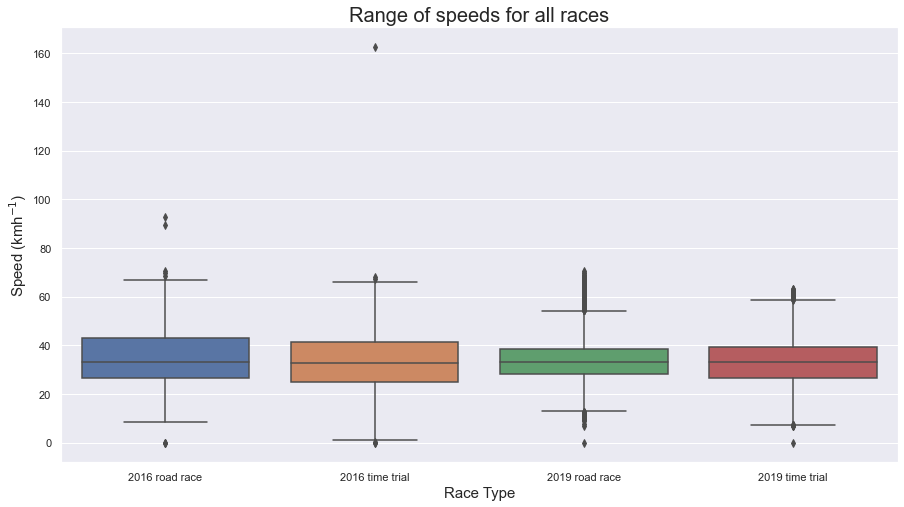

In [212]:
plt.figure(figsize=(15,8))

ax= sns.boxplot(x='race type', y='speed', data= allDf)

plt.xlabel('Race Type', size=15)
plt.ylabel('Speed (kmh$^{-1}$)', size=15)
plt.title('Range of speeds for all races', size=20)

I believe we can simply remove the outliers seen in tt_16 and rr_16. There are many data points in this data set so iit should not affect the overall analysis. I've decided that anything above 80 is an outlier as according to [this link](https://en.wikipedia.org/wiki/Bicycle_performance), the max recorded speed a bicycle has achieved is 100kmph. I don't think Steve achieved this speed.


Checking for outliers. As mentioned previously, a speed outlier to check for would be when there are speeds over 80kmph. We're able to apply this 'filter' to the data because realisticaly, we don't think the rider has achieved these speeds. Another indicator to confirm if the speeds are true is if the surrounding speeds are similar. They would be similar in a way that is decreasing or increasing slightly with each observation. In the plot above, we can see the speeds above 80 for races rr16 and tt16 have no neighbours, therefore they are outliers. 

keeping all rows except those that are greater than 80. In other words, removing all rows greater than 80. I originally thought this would substitute the values in 'speed' for boolean values instead. Like how a mask works. But this is not the case. This will display all the rows where the speed is less than 80. 

In [213]:
allDf_clean = allDf[allDf['speed'] < 80] 

# also applying to the DFs separately:

rr16_clean = rr16[rr16['speed'] < 80]
tt16_clean = tt16[tt16['speed'] < 80]
rr19_clean = rr19[rr19['speed'] < 80]
tt19_clean = tt19[tt19['speed'] < 80]

checking the amount of outliers removed:

In [214]:
allDf.shape[0] - allDf_clean.shape[0]

3

This makes sense as we can visually see only a few outliers in the boxplot. 

Plotting again with the outliers removed

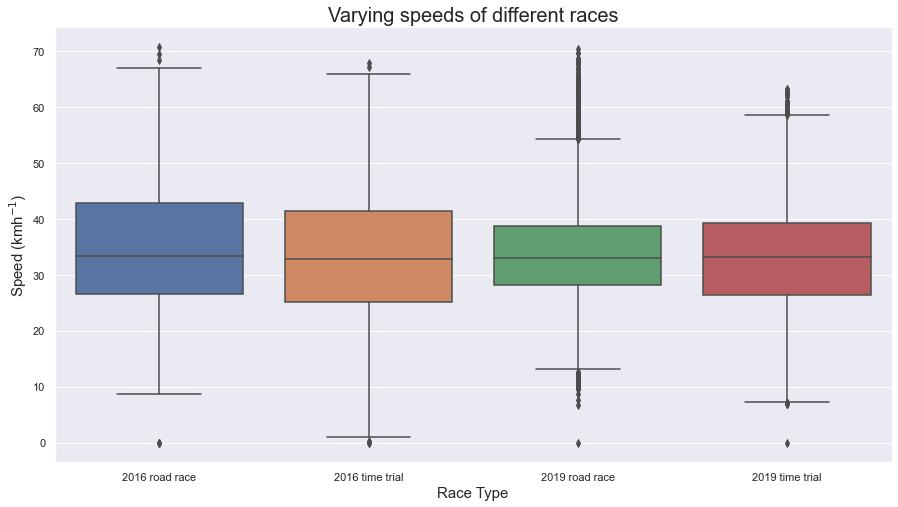

In [215]:
plt.figure(figsize=(15,8))

ax = sns.boxplot(x='race type', y='speed', data= allDf_clean)
ax.set_xlabel('Race Type', fontsize=15)
ax.set_ylabel('Speed (kmh$^{-1}$)', fontsize=15)
ax.set_title('Varying speeds of different races', fontsize= 20)

plt.show()

We can see there are still 'outliers' at the zero mark, and above the maximum. These are outliers defined by how the boxplot is produced. They aren't necessarily 'bad' data, but relate more to the boxplot itself. It should be noted that any time data is removed from the DF, the shape of the boxplot and the values determined by the boxplot will also change. This is due to the IQR changing and the quantiles. In this case it's not obvious because only 3 points of data have been removed. 

Instead of removing the 3 outliers, we can try correcting them. This would involve taking the average of the two above the outlier and the two below. First we will organise the DF a little bit by resetting the index so it will be easier to index into the DF. We will also add a column to depict which race is in question. This will be handy for plotting and distinguishing between DFs when we append all the DFs. 

First, reset the index column which will create a new column named 'index'. This new column will contain the data from the old index. The new index will be numbered as we traditionally expect, starting from 0. 

In [216]:
rr16_reset = rr16.reset_index().copy(deep=True)

In [217]:
rr16_reset = rr16_reset.rename(columns={'index':'observation'})

In [218]:
rr16_reset.head()

,observation,latitude,longitude,elevation,temperature,cadence,hr,distance,elevation_gain,speed,timedelta,race type
0,2016-05-14 04:02:41+00:00,-33.415561,151.222303,208.6,29.0,40.0,102.0,0.000000,0.0,0.000000,NaN,2016 road race
1,2016-05-14 04:02:42+00:00,-33.415534,151.222289,208.6,29.0,40.0,102.0,0.003271,0.0,11.777020,1.0,2016 road race
2,2016-05-14 04:02:46+00:00,-33.415398,151.222180,208.6,29.0,40.0,103.0,0.018194,0.0,16.375033,4.0,2016 road race
3,2016-05-14 04:02:49+00:00,-33.415264,151.222077,208.6,29.0,55.0,106.0,0.017703,0.0,21.243901,3.0,2016 road race
4,2016-05-14 04:02:51+00:00,-33.415160,151.222013,208.6,29.0,61.0,109.0,0.013001,0.0,23.401217,2.0,2016 road race


Putting this into a function to for practice and reduce the number of cells run. 

In [219]:
def resetIndexFn(myDf, raceTypeString):
    myDf_reset = myDf.reset_index()
    
    myDf_reset = myDf_reset.rename(columns={'index':'observation'})
    
    myDf_reset['race type']= raceTypeString

    return myDf_reset

Note, in the above cell we added a column to show what race type. This has been done previously, though it's being called again. It will not add another column, it will simply overwrite the current column.

Using `resetIndexFn` on all the DFs

In [220]:
rr16_reset = resetIndexFn(rr16, '2016 road race')
tt16_reset = resetIndexFn(tt16, '2016 time trial')
rr19_reset = resetIndexFn(rr19, '2019 road race')
tt19_reset = resetIndexFn(tt19, '2019 time trial')

Finding the outliers

In [221]:
rr16_reset[rr16_reset['speed']>80].index

Int64Index([482, 1299], dtype='int64')

In [222]:
tt16_reset[tt16_reset['speed']>80].index

Int64Index([869], dtype='int64')

In [223]:
rr19_reset[rr19_reset['speed']>80].index

Int64Index([], dtype='int64')

In [224]:
tt19_reset[tt19_reset['speed']>80].index

Int64Index([], dtype='int64')

This race only has two speed outliers that are faster than 80kmph for the 2016 road race. What was output above is the indices where the speed outliers exist. We can store these to call later. 

In [225]:
rr16_outliersIndex = rr16_reset[rr16_reset['speed']>80].index
tt16_outliersIndex = tt16_reset[tt16_reset['speed']>80].index

Taking the average of the two above and below the outlier. We will then store that value to update the DF with the corrected value.

In [226]:
rr16_reset['speed'].iloc[rr16_outliersIndex[0]-2:rr16_outliersIndex[0]+3]

480    30.896364
481     0.000000
482    89.394487
483    30.540313
484    31.287927
Name: speed, dtype: float64

As we can see above, next to the outlier (89.39) there is a speed of 0. This is also an outlier as it's highly unlikely the speed dropped to zerro then up to 90kmph. We can check this isn't the case by looking at the observation window and the elevation_gain of the surrounding rows. 

In [227]:
rr16_reset[['speed', 'elevation_gain', 'timedelta']].iloc[rr16_outliersIndex[0]-3:rr16_outliersIndex[0]+3]

,speed,elevation_gain,timedelta
479,31.990190,0.0,7.0
480,30.896364,0.0,6.0
481,0.000000,0.0,2.0
482,89.394487,0.4,1.0
483,30.540313,0.6,1.0
484,31.287927,0.4,1.0


So what we're looking at is from row 480 to 481, the rider went from 30kmph to zero in 6 seconds. This is possible although considering the next row 482 speeds up to 90 in 1 second, we definitely know something is wrong with the recording device. 

In [228]:
rr16_reset['speed'].iloc[rr16_outliersIndex[0]-2:rr16_outliersIndex[0]]

480    30.896364
481     0.000000
Name: speed, dtype: float64

In [229]:
upper2 =  (rr16_reset['speed'].iloc[rr16_outliersIndex[0]-2:rr16_outliersIndex[0]].values[0] +
           rr16_reset['speed'].iloc[rr16_outliersIndex[0]-2:rr16_outliersIndex[0]].values[1])
lower2 = ( rr16_reset['speed'].iloc[rr16_outliersIndex[0]+1:rr16_outliersIndex[0]+3].values[0] +
           rr16_reset['speed'].iloc[rr16_outliersIndex[0]+1:rr16_outliersIndex[0]+3].values[1])
mean = (upper2+lower2)/4

rr16_clean = rr16_reset.copy(deep=True)
rr16_clean['speed'].iloc[rr16_outliersIndex[0]] = mean 

rr16_clean['speed'].iloc[rr16_outliersIndex[0]-2:rr16_outliersIndex[0]+3]


C:\Users\Rudol\anaconda3\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


480    30.896364
481     0.000000
482    23.181151
483    30.540313
484    31.287927
Name: speed, dtype: float64

We can see disadvantage in using this method as the value for 482 is quite low compared to it's surroundings. This is due to the zero value in row 481. We might as well fix that while we're here as it's highly unlikely the rider stopped and started in the middle of a race. 

In [230]:
rr16_clean['speed'].iloc[481] = mean 
rr16_clean['speed'].iloc[rr16_outliersIndex[0]-2:rr16_outliersIndex[0]+3]

480    30.896364
481    23.181151
482    23.181151
483    30.540313
484    31.287927
Name: speed, dtype: float64

Perfoming the same correction on the other DFs using a function

In [231]:
def cleanFn(myDf): 
    outlierIndex = myDf[myDf['speed']>80].index
    
    for i in outlierIndex:
        print(i)
        upper2 =  myDf['speed'].iloc[i -2:i].values[0] + myDf['speed'].iloc[i -2:i].values[1]
        lower2 = myDf['speed'].iloc[i+1:i+3].values[0] + myDf['speed'].iloc[i+1:i+3].values[1]
        mean = (upper2+lower2)/4
        myDf['speed'].iloc[i] = mean 
        
        if myDf['speed'].iloc[i-1] == 0:
            myDf['speed'].iloc[i-1]=mean
        if myDf['speed'].iloc[i+1] ==0:
            myDf['speed'].iloc[i+1] = mean

#         myDf['speed'].iloc[i-2:i+3]
#         print(myDf['speed'].iloc[i-2:i+3])
    return myDf

First, let's confirm the function works correctly:

In [232]:
rr16_clean = cleanFn(rr16_reset)

482
1299


They have been corrected along with neighbouring outliers being zero. Applying this to the other DF that had outlliers according to our definition

In [233]:
tt16_clean = cleanFn(tt16_reset)

869


In [234]:
rr19_clean = cleanFn(rr19_reset)

In [235]:
tt19_clean = cleanFn(tt19_reset)

There is no outputs from calling the function for the 2019 races, so there are no outliers that exist above 80kmph. 

In [236]:
allDf_clean = rr16_clean.append([tt16_clean, rr19_clean, tt19_clean])

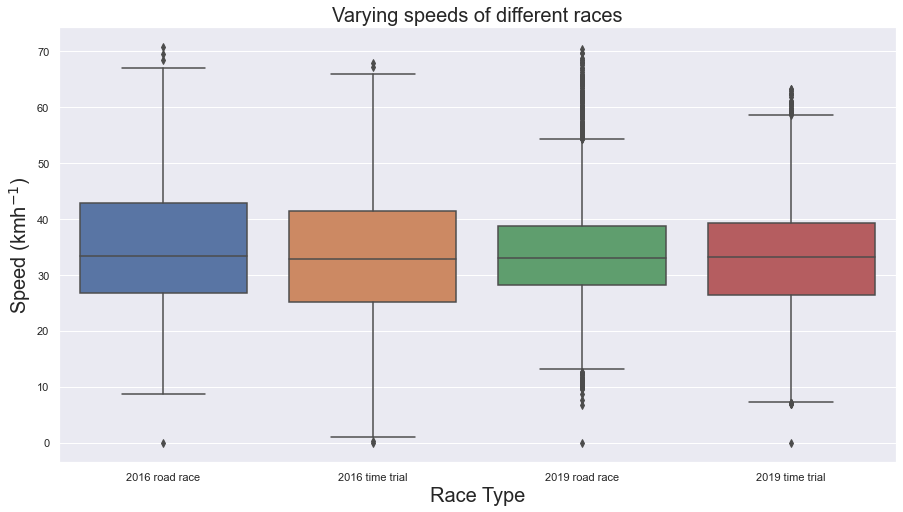

In [237]:
# plotting again

plt.figure(figsize=(15,8))

ax = sns.boxplot(x='race type', y='speed', data= allDf_clean)
ax.set_xlabel('Race Type', fontsize=20)
ax.set_ylabel('Speed (kmh$^{-1}$)', fontsize=20)
ax.set_title('Varying speeds of different races', fontsize= 20)

plt.show()

### **Analysis**: 

Now that most of the outliers have been removed, the y axis has decreased and we can see variations in the speeds more clearly. 

Both races in 2016 had higher variations in speed than those in 2019 and 2016. The earlier races also had a higher maximum speed and a lower minimum speed. The 2016 road race having the fastest speed overall and the 2019 time trial having the slow speed overall. Perhaps the races in 2019 had lower variations in speed due to the rider aging. The 2019 road race has a smaller range of speeds compared to the 2019 time trial. Having a smaller range in speeds may indicate that the mean speeds are higher in general. 

# Question 3:
Compare the speeds achieved in the two time trials (three years apart).  As well as looking at the averages, can you see where in the ride one or the other is faster.  

We want to compare the speeds of the two tiime trial races. A comparison can include the mean of the races, the variations of speed over time. I dont think we can plot time because the observation column is in the wrong format. Can probably use the index since it's numbered. we would then say time as at observation 1 or 1000 for example. Those observations will have their own time stored in the observation column. 

We know from the `summaryFn`s for these races that they took 0.7397 and 0.7375hrs respectively to complete the races. We can also see the mean speeds of both races:


In [238]:
tt19_clean['speed'].mean()

33.05782378815691

In [239]:
tt16_clean['speed'].mean()

33.45880677030278

In [240]:
print(f'tt19 mean speed: {round(tt19_clean["speed"].mean(),2)}')
print(" ")
print(f'tt16 mean speed: {round(tt16_clean["speed"].mean(),2)}')

tt19 mean speed: 33.06
 
tt16 mean speed: 33.46


The average speed for both races are very similar. There isn't much to infer from here besides no improvement in the pace between the races. Both races were finished in a similar time and similar average speed. Although, as we've seen previously, the tt19 had a lower hrMean which can be seen in `summaryFn` indicating the fitness in the rider has improved. 

Plotting the overall distance covered, we will have to first find the cummulative distance the rider travelled. 

In [241]:
tt19_reset['distance_cumsum'] = tt19_reset['distance'].cumsum()
tt16_clean['distance_cumsum'] = tt16_clean['distance'].cumsum()

Text(0.5, 1.0, 'Comparison of speeds for the time trial races')

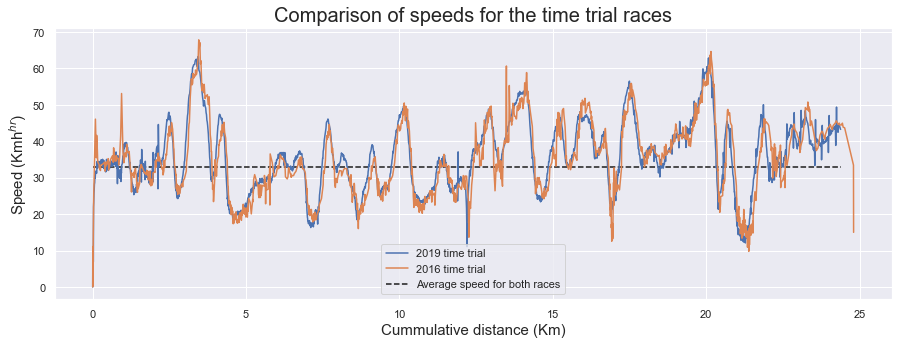

In [242]:
plt.figure(figsize=(15,5))

sns.lineplot(x= 'distance_cumsum', y= 'speed', data = tt19_reset, label= '2019 time trial')
sns.lineplot(x= 'distance_cumsum', y= 'speed', data = tt16_clean, label= '2016 time trial')
plt.hlines(y=tt19_reset['speed'].mean(), xmin=0, xmax= tt19_reset['distance_cumsum'].max(), 
           linestyle = 'dashed', label= 'Average speed for both races')

plt.legend()
plt.xlabel('Cummulative distance (Km)', size=15)
plt.ylabel('Speed (Kmh$^{hr}$)', size=15)
plt.title('Comparison of speeds for the time trial races', size=20)

The points match up well. I did not believe it would be this close as the number of rows in tt19 is nearly double that of tt16. i assumed more data should have a smoother shape. Considering tt19 has more observations, we can see the lines are slightly smoother. 

We can smooth out the entire dataset for both DFs by using the `rolling_mean` function. 

In [243]:
tt16_roll = tt16_clean.copy(deep=True)

In [244]:
tt16_roll['speed']= tt16_roll['speed'].rolling(10,min_periods= 1).mean()

In [245]:
rr16_roll = rr16_clean.copy(deep=True)
rr16_roll['speed']= rr16_roll['speed'].rolling(10,min_periods= 1).mean()

rr19_roll = rr19_clean.copy(deep=True)
rr19_roll['speed']= rr19_roll['speed'].rolling(10,min_periods= 1).mean()

Comparing the original and the smoothed data

In [246]:
tt16_roll[['speed', 'timedelta']].head()

,speed,timedelta
0,0.000000,NaN
1,5.544567,2.0
2,4.026805,6.0
3,3.082518,23.0
4,3.614428,1.0


In [247]:
tt16_clean[['speed', 'timedelta']].head()

,speed,timedelta
0,0.000000,NaN
1,11.089134,2.0
2,0.991282,6.0
3,0.249655,23.0
4,5.742071,1.0


The values have drastically changed. The smoothing function requires 10 different rows to compute the next value. 

Plotting the original against the rolled to see if there are any improvements in the amount of 'noise'. 

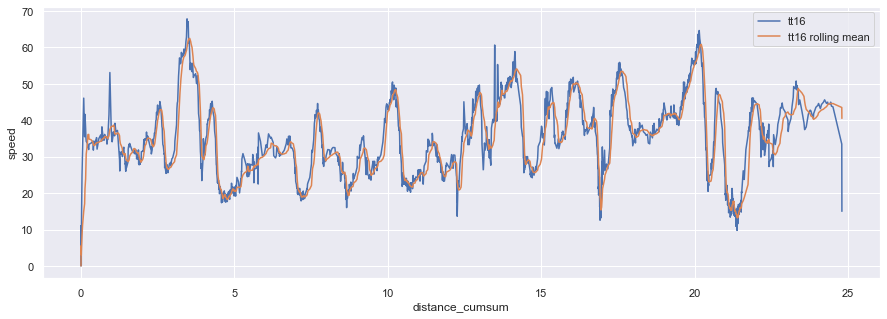

In [248]:
plt.figure(figsize=(15,5))

sns.lineplot(x= 'distance_cumsum', y= 'speed', data = tt16_clean, label= 'tt16')
sns.lineplot(x= 'distance_cumsum', y= 'speed', data = tt16_roll, label= 'tt16 rolling mean')
plt.legend()

Using the documentation for subplots from here

https://seaborn.pydata.org/tutorial/axis_grids.html

We use subplots to show the two plots in one output cell. 

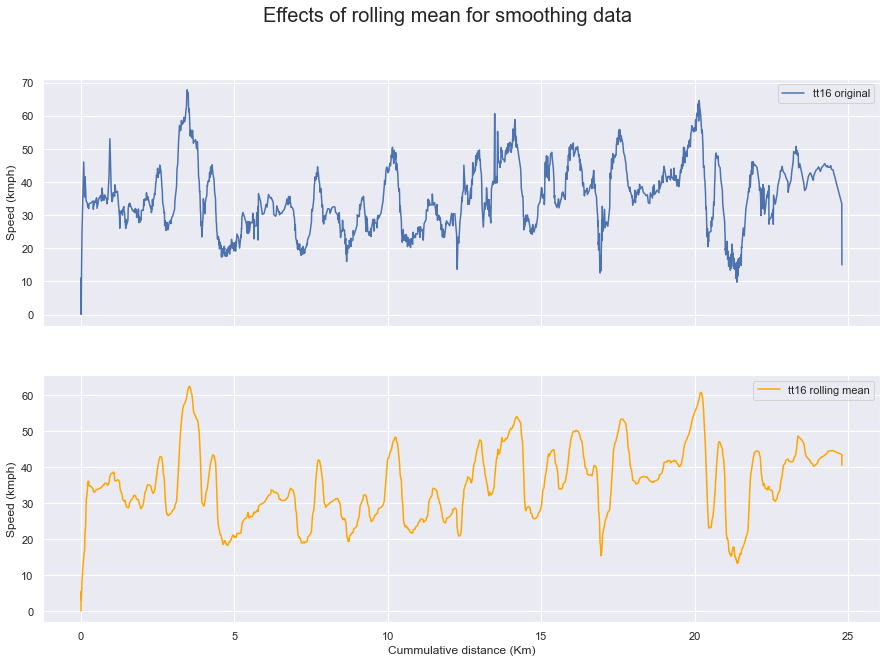

In [249]:
fig, axes = plt.subplots(2, figsize=(15,10), sharex= True)
fig.suptitle('Effects of rolling mean for smoothing data', size = 20)

ax1 = sns.lineplot(ax=axes[0], x= 'distance_cumsum', y= 'speed', data = tt16_clean, 
                   label= 'tt16 original')

ax2 = sns.lineplot(ax = axes[1], x= 'distance_cumsum', y= 'speed', data = tt16_roll, 
                   label= 'tt16 rolling mean', color= 'orange')

ax1.set(ylabel = 'Speed (kmph)')
ax2.set(ylabel = 'Speed (kmph)', xlabel = 'Cummulative distance (Km)')

plt.legend()

We can see well the effects the `rolling_mean` function had on the data. Let's apply this to the tt19 data. 

In [250]:
tt19_roll = tt19_reset.copy(deep= True)

In [251]:
tt19_roll['speed'] = tt19_reset['speed'].rolling(10,min_periods= 1).mean()

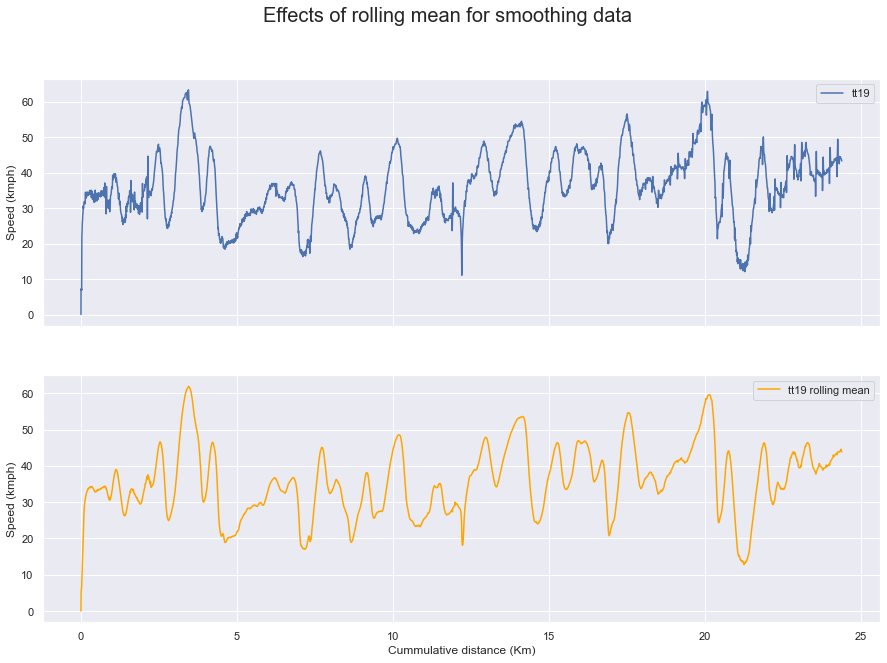

In [252]:
fig, axes = plt.subplots(2, figsize=(15,10), sharex= True)
fig.suptitle('Effects of rolling mean for smoothing data', size = 20)

ax1 = sns.lineplot(ax=axes[0], x= 'distance_cumsum', y= 'speed', data = tt19_reset, label= 'tt19')

ax2 = sns.lineplot(ax = axes[1], x= 'distance_cumsum', y= 'speed', data = tt19_roll, label= 'tt19 rolling mean', color= 'orange')

ax1.set(ylabel = 'Speed (kmph)')
ax2.set(ylabel = 'Speed (kmph)', xlabel = 'Cummulative distance (Km)')

plt.legend()

Let's see how the tt19 and tt16 smoothed looks like on the same plot

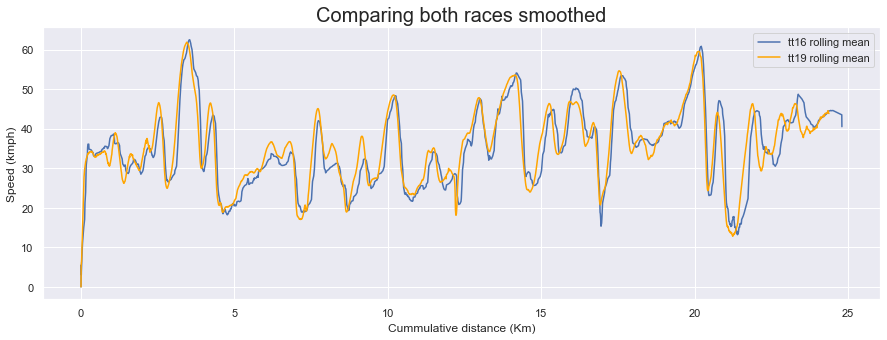

In [253]:
plt.figure(figsize=(15,5))

plt.title('Comparing both races smoothed', size = 20)

ax1 = sns.lineplot( x= 'distance_cumsum', y= 'speed', data = tt16_roll, label= 'tt16 rolling mean')

ax2 = sns.lineplot( x= 'distance_cumsum', y= 'speed', data = tt19_roll, label= 'tt19 rolling mean', color= 'orange')

ax1.set(ylabel = 'Speed (kmph)')
ax2.set(ylabel = 'Speed (kmph)', xlabel = 'Cummulative distance (Km)')

plt.legend()


There are some areas that can be seen where one race is faster than  the other. Let's try to mark the obvious peaks and compare the speeds at those moments. We will only consider peaks that are above the average speed. There are still many peaks above the mean speed so we will also include a prominence factor in the peaks. This will find the most prominent peaks, reducing the total number of peaks, thus making it the most 'obvious' peaks. The peaks will be marked with a cross and a vertical dashed line going through the peak.

In [254]:
from scipy.signal import find_peaks

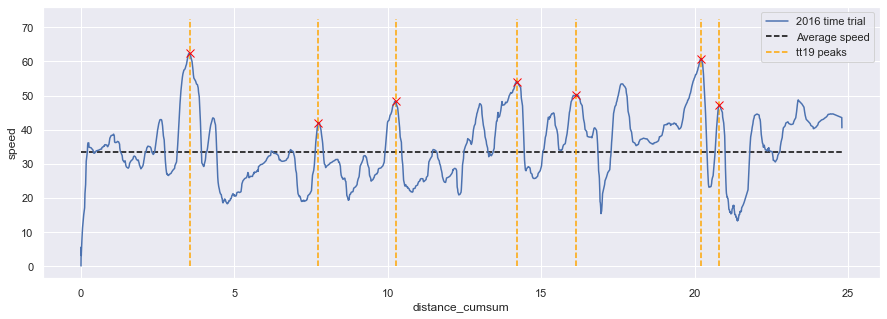

In [255]:
plt.figure(figsize=(15,5))


tt16_peaks, _=find_peaks(tt16_roll['speed'], height= tt16_roll['speed'].mean(), prominence= 22)

sns.lineplot(x= 'distance_cumsum', y= 'speed', data = tt16_roll, label= '2016 time trial')

plt.hlines(y=tt16_roll['speed'].mean(), xmin=0, xmax= tt16_roll['distance_cumsum'].max(),
           linestyle = 'dashed', label= 'Average speed', color='black')

plt.plot( tt16_roll['distance_cumsum'][tt16_peaks], tt16_roll['speed'][tt16_peaks],
         "x",color='red', markersize= 8)

plt.vlines(x= tt16_roll['distance_cumsum'][tt16_peaks], ymin=tt16_roll['speed'].min(), 
           ymax= tt16_roll['speed'].max()+10 ,linestyle = 'dashed', label= 'tt19 peaks', 
           color = 'orange')

plt.legend()

Now let's compare the speeds at the peaks between the races, marking whichever racce was faster at the peak. 

In [256]:
tt19_peaks, _=find_peaks(tt19_roll['speed'], height= tt19_roll['speed'].mean(), prominence= 22)

Text(0.5, 1.0, 'Comparison of most obvious peaks')

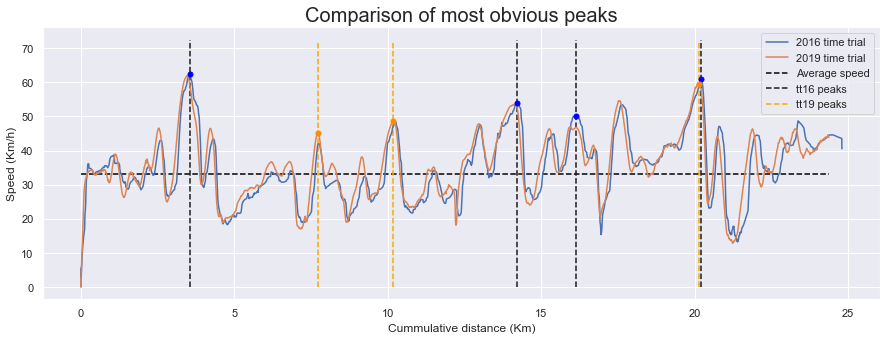

In [257]:
plt.figure(figsize=(15,5))

sns.lineplot(x= 'distance_cumsum', y= 'speed', data = tt16_roll, label= '2016 time trial')
sns.lineplot(x= 'distance_cumsum', y= 'speed', data = tt19_roll, label= '2019 time trial')

plt.hlines(y=tt19_roll['speed'].mean(), xmin=0, xmax= tt19_roll['distance_cumsum'].max(),
           linestyle = 'dashed', label= 'Average speed', color='black')

tt16_peaksNew= []
tt19_peaksNew= []
for i, val in enumerate(tt19_peaks):
    if tt19_roll['speed'].iloc[val] > tt16_roll['speed'].iloc[tt16_peaks[i]]:
        tt19_peaksNew.append(val)
        plt.plot( tt19_roll['distance_cumsum'][val], tt19_roll['speed'][val],
         ".",color='darkorange', markersize= 10)
    else:
        tt16_peaksNew.append(tt16_peaks[i])
        plt.plot( tt16_roll['distance_cumsum'][tt16_peaks[i]], tt16_roll['speed'][tt16_peaks[i]],
         ".", markersize= 10 , color= 'blue')



plt.vlines(x= tt16_roll['distance_cumsum'][tt16_peaksNew], ymin=tt16_roll['speed'].min(), 
           ymax= tt16_roll['speed'].max()+10 ,linestyle = 'dashed', label= 'tt16 peaks')

plt.vlines(x= tt19_roll['distance_cumsum'][tt19_peaksNew], ymin=tt19_roll['speed'].min(), 
           ymax= tt19_roll['speed'].max()+10 ,linestyle = 'dashed', label= 'tt19 peaks', color = 'orange')



plt.legend()

plt.xlabel('Cummulative distance (Km)')
plt.ylabel('Speed (Km/h)')
plt.title('Comparison of most obvious peaks', size= 20)

We can see visually which race is faster thanks to the marked peaks. We can also check the value by indexing into the DFs with the variables. The blue race has more peaks that are faster for our chosen peaks. The last peak on the right did not compare correctly as the positions of the peaks did not line up correctly. This would take a lot of time to implement because the dimensions of the DFs are not the same. Therefore, it is not a matter of indexing 1:1 from one DF to the other DF. 

Let's do the same over the span of time passed during the race. 

We first have to get the cummulative time passed, similarly to how we did for the cummulative distance. We will have to make a new column. We can use the method we did in `summaryFn` to get the time taken to complete the race or we can use a method similar to distance_cumsum. The Latter will be more accurate as it's using the difference between all the observations to get the total time. 

Help from https://stackoverflow.com/questions/10663720/how-to-convert-a-time-string-to-seconds

https://stackoverflow.com/questions/34846146/how-to-calculate-differences-between-consecutive-rows-in-pandas-data-frame

In [258]:
from datetime import datetime

In [259]:
tt16_roll['time'] = tt16_roll['observation'].copy(deep=True)

In [260]:
for i, val in enumerate(tt16_roll['observation']):
# this converts the timestamp to an integer in seconds
    timeString= val.strftime("%m/%d/%Y, %H:%M:%S")
    stripTime = datetime.strptime(timeString, "%m/%d/%Y, %H:%M:%S")
    totalSeconds = stripTime.minute*60 + stripTime.hour*3600 + stripTime.second
    tt16_roll['time'][i] = totalSeconds


<ipython-input-260-1880e879e4c9>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tt16_roll['time'][i] = totalSeconds


In [261]:
tt16_roll['time'] = (tt16_roll['time'].diff().cumsum())/3600 #in hours 

tt16_roll['time'] 

0            NaN
1       0.000556
2       0.002222
3       0.008611
4       0.008889
          ...   
1536      0.7525
1537    0.753056
1538    0.754167
1539    0.762778
1540    0.763056
Name: time, Length: 1541, dtype: object

Putting this in a function

In [262]:
def timeFn(myDf):
    myDf['time'] = myDf['observation'].copy(deep=True)
    for i, val in enumerate(myDf['observation']):
# this converts the timestamp to an integer in seconds
        timeString= val.strftime("%m/%d/%Y, %H:%M:%S")
        stripTime = datetime.strptime(timeString, "%m/%d/%Y, %H:%M:%S")
        totalSeconds = stripTime.minute*60 + stripTime.hour*3600 + stripTime.second
        myDf['time'][i] = totalSeconds/3600
        
        
    myDf['time'] = myDf['time'].diff().cumsum() # in seconds 
    myDf['time'].iloc[0] = 0

    return myDf

In [263]:
tt19_roll = timeFn(tt19_roll)

<ipython-input-262-01551c41f0f0>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  myDf['time'][i] = totalSeconds/3600
C:\Users\Rudol\anaconda3\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


In [264]:
tt16_roll = timeFn(tt16_roll)

<ipython-input-262-01551c41f0f0>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  myDf['time'][i] = totalSeconds/3600
C:\Users\Rudol\anaconda3\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


In [265]:
rr16_roll = timeFn(rr16_roll)

<ipython-input-262-01551c41f0f0>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  myDf['time'][i] = totalSeconds/3600
C:\Users\Rudol\anaconda3\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


In [266]:
rr19_roll = timeFn(rr19_roll)

<ipython-input-262-01551c41f0f0>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  myDf['time'][i] = totalSeconds/3600
C:\Users\Rudol\anaconda3\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


Now we should be able to simply plot exactly what we had above, just changing the DF columns

Text(0.5, 1.0, 'Comparison of most obvious peaks')

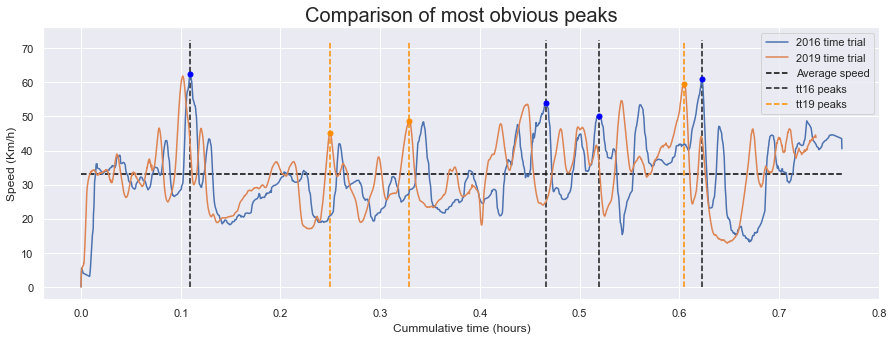

In [267]:
plt.figure(figsize=(15,5))
tt19_peaks, _ =find_peaks(tt19_roll['speed'], height= tt19_roll['speed'].mean(), prominence= 22)
tt16_peaks, _ =find_peaks(tt16_roll['speed'], height= tt16_roll['speed'].mean(), prominence= 22)


sns.lineplot(x= 'time', y= 'speed', data = tt16_roll, label= '2016 time trial')
sns.lineplot(x= 'time', y= 'speed', data = tt19_roll, label= '2019 time trial')

plt.hlines(y=tt19_roll['speed'].mean(), xmin=0, xmax= tt16_roll['time'].max(),
           linestyle = 'dashed', label= 'Average speed', color='black')

tt16_peaksNew= []
tt19_peaksNew= []
for i, val in enumerate(tt19_peaks):
    if tt19_roll['speed'].iloc[val] > tt16_roll['speed'].iloc[tt16_peaks[i]]:
        tt19_peaksNew.append(val)
        plt.plot( tt19_roll['time'][val], tt19_roll['speed'][val],
         ".",color='darkorange', markersize= 10)
    else:
        tt16_peaksNew.append(tt16_peaks[i])
        plt.plot( tt16_roll['time'][tt16_peaks[i]], tt16_roll['speed'][tt16_peaks[i]],
         ".", markersize= 10 , color= 'blue')


plt.vlines(x= tt16_roll['time'][tt16_peaksNew], ymin=tt16_roll['speed'].min(), 
           ymax= tt16_roll['speed'].max()+10 ,linestyle = 'dashed', label= 'tt16 peaks')

plt.vlines(x= tt19_roll['time'][tt19_peaksNew], ymin=tt19_roll['speed'].min(), 
           ymax= tt19_roll['speed'].max()+10 ,linestyle = 'dashed', label= 'tt19 peaks', color = 'darkOrange')





plt.legend()

plt.xlabel('Cummulative time (hours)')
plt.ylabel('Speed (Km/h)')
plt.title('Comparison of most obvious peaks', size= 20)
# plt.xlim(0,0.1)

the 2016 race took longer so as we can see in the above plot, it finished later in the race. There are instances where the 2016 race is faster at the peaks, but we find that overall, the 2019 race was faster. I believe the races are not lined up because as the race progresses, the 2019 race is getting getting further into the race at the same observations. Another reason is due to the size of the DFs are different. Different number of observations will have different results. Though I can't see why cummulative distance plots did not behave the same. 

In [268]:
print(f'tt19 took {round(tt19_roll["time"].iloc[-1],4)} hours to complete the race')

tt19 took 0.7372 hours to complete the race


In [269]:
print(f'tt19 took {round(tt16_roll["time"].iloc[-1],4)} hours to complete the race')

tt19 took 0.7631 hours to complete the race


# Question 4: 
From the elevation_gain field you can see whether the rider is _climbing_ , _descending_ or on the _flat_.   Use this to calculate the average speeds in those three cases (climbing, flat or descending).  Note that _flat_ might not be zero elevation_gain but might allow for slight climbs and falls.  

In [270]:
tt16_roll['timedelta'].describe()

count    1540.000000
mean        1.783766
std         1.822713
min         1.000000
25%         1.000000
50%         1.000000
75%         2.000000
max        31.000000
Name: timedelta, dtype: float64

Thiis means that during the observation window of 30s, the biker could have gone uphiilll, then flat then downhill. but the 'elevation_gain' column may only show 0 in that observation. I wanted to first find instances where there may be a bump in the road. When considering 3 consecutiive observations, this looks like flat, incline, flat. So an instant change from flat to incline to flat again. We would find these index locations and use them to remove the row from the DF. 

In [271]:
posBump = tt16_roll.query('0 <= elevation_gain <= 0.1').index

In [272]:
posBump.shape

(452,)

In [273]:
tt16_roll['elevation_gain'][posBump] = 0

<ipython-input-273-a713788c8ba4>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tt16_roll['elevation_gain'][posBump] = 0


In [274]:
tt16_roll['elevation_gain'][posBump].describe()

count    452.0
mean       0.0
std        0.0
min        0.0
25%        0.0
50%        0.0
75%        0.0
max        0.0
Name: elevation_gain, dtype: float64

In [275]:
tt16_roll.query('0 <= elevation_gain <= 0.1')['elevation_gain'].describe()

count    452.0
mean       0.0
std        0.0
min        0.0
25%        0.0
50%        0.0
75%        0.0
max        0.0
Name: elevation_gain, dtype: float64

the application to remove the small increments worked. Time to do it for the negative end. 

In [276]:
negBump = tt16_roll.query('-0.1 <= elevation_gain <= 0').index

In [277]:
negBump.shape

(452,)

In [278]:
tt16_roll['elevation_gain'][negBump] = 0

<ipython-input-278-e640db5f0b0e>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tt16_roll['elevation_gain'][negBump] = 0


In [279]:
tt16_roll['elevation_gain'][negBump].describe()

count    452.0
mean       0.0
std        0.0
min        0.0
25%        0.0
50%        0.0
75%        0.0
max        0.0
Name: elevation_gain, dtype: float64

let's now plot the change in elevation over time. This will give a visual idea of how much incline / decline the rider experienced at a certain time. 

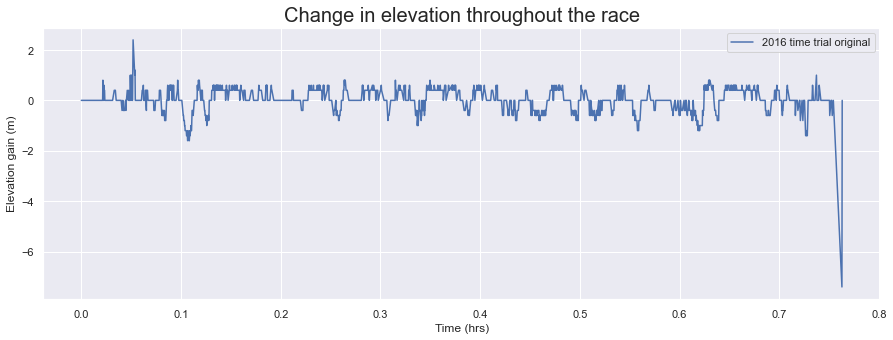

In [280]:
plt.figure(figsize=(15,5))


sns.lineplot(x= 'time', y= 'elevation_gain', data = tt16_roll, label= '2016 time trial original')

plt.legend()
plt.xlabel('Time (hrs)')
plt.ylabel('Elevation gain (m)')
plt.title('Change in elevation throughout the race', size=20)
# plt.xlim(0,.04)
plt.show()

Let's check out what happens at the steep decline at the end. Determining what that value is:

In [281]:
tt16_roll['elevation_gain'].min()

-7.400000000000006

Finding the row location of this value

In [282]:
tt16_roll.query('-8 <= elevation_gain <= -6')

,observation,latitude,longitude,elevation,temperature,cadence,hr,distance,elevation_gain,speed,timedelta,race type,distance_cumsum,time
1539,2016-07-02 23:51:16+00:00,-33.418333,151.223478,108.0,11.0,64.0,143.0,0.288175,-7.4,43.523388,31.0,2016 time trial,24.798722,0.762778


In [283]:
tt16_roll[['elevation_gain','timedelta']][1537:1542]

,elevation_gain,timedelta
1537,-0.6,2.0
1538,0.0,4.0
1539,-7.4,31.0
1540,0.0,1.0


This is most likely an outlier. Although considering timedelta is 31s, perhaps there is more information contained in this observation that was not recorded correctly. 

Let's see if smoothing helps. 

In [284]:
tt16_roll['elevation_gain'] = tt16_roll['elevation_gain'].rolling(10,min_periods= 1).mean()

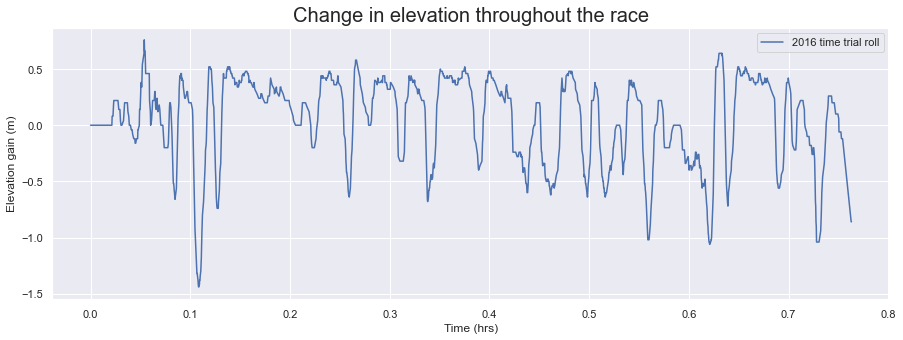

In [285]:
plt.figure(figsize=(15,5))


sns.lineplot(x= 'time', y= 'elevation_gain', data = tt16_roll, label= '2016 time trial roll')


plt.legend()
plt.xlabel('Time (hrs)')
plt.ylabel('Elevation gain (m)')
plt.title('Change in elevation throughout the race', size=20)
plt.show()

The outlier has been removed thanks to the smoothing function. 

I believe the zig zagging motion of the plot represents the uphill, followed by a downhill. This would make sense because if it the race was predominantly on an incline, then it would suggest they rode up a mountain and did not descend. Which is fine, though is not represented by this plot. 



Next to work on would be the finding the speeds whenever there are incline, decline and flat. This is where we ccan perhaps use the method for the 'binariser'. Then we can simply average the speeds when there is a 1 (for incline), -1 (for declinie) and 0 for flat. 


Creating a new column `idf` for incline decline or flat. 

In [286]:
tt16_roll['idf'] = 0

In [287]:
index_decl = tt16_roll[tt16_roll['elevation_gain'] < 0]['elevation_gain'].index.copy(deep=True)
tt16_roll['idf'].iloc[index_decl] = -1

index_incl = tt16_roll[tt16_roll['elevation_gain'] > 0]['elevation_gain'].index.copy(deep=True)
tt16_roll['idf'].iloc[index_incl] = 1

index_flat = tt16_roll[tt16_roll['elevation_gain'] == 0]['elevation_gain'].index.copy(deep=True)
tt16_roll['idf'].iloc[index_flat] = 0

C:\Users\Rudol\anaconda3\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


In [288]:
tt16_inclineSpeed = tt16_roll[tt16_roll['idf'] ==1]['speed'].mean()
tt16_inclineSpeed

26.349807068773064

In [289]:
tt16_flatSpeed = tt16_roll[tt16_roll['idf'] ==0]['speed'].mean()
tt16_flatSpeed 

31.15098446093074

In [290]:
tt16_declineSpeed = tt16_roll[tt16_roll['idf'] ==-1]['speed'].mean()
tt16_declineSpeed

42.947332054657956

As expected, the average speed on a decline `(idf-1)` is faster than the other instances. The average speed on an inclline is less than the other instances. 

Some things to note here and assumptions made: 
- removing the bumps from the DF is too advanced for us at this stage. it would involve looking at instances where the change in elevation_gain goes from flat, to incline, decline then flat. This looks like a change in values as 

$\hspace{5cm}$$\big[$0 $\xrightarrow{flat}$ 0 $\xrightarrow{incline}$ 0.2 $\xrightarrow{decline}$ 0 $\xrightarrow{flat}$ 0 $\big]$. 

- The outliler with an elevation_gain of -7m within one observation. This would normally be impossible, as it would reflect the rider suddenly dropping. Although considering there was a timedelta of 31s at this observation, we may be able to assume the rider went on a decline during that observation. The rest of the race remained within an elevation_gain of -2m, so it would be better to remove the outlier, or fix it with rolling mean. 

Doing the same for the rest of the DFs

Putting the above process into a function

In [291]:
def elevationSpeedsFn(myDf):

    myDf_roll = myDf.copy(deep=True)
    myDf_roll['speed']= myDf_roll['speed'].rolling(10,min_periods= 1).mean()

    posGain = myDf_roll.query('0 <= elevation_gain <= 0.1').index
    negGain = myDf_roll.query('-0.1 <= elevation_gain <= 0').index

    myDf_roll['elevation_gain'][posGain] = 0
    myDf_roll['elevation_gain'][negGain] = 0
    
    myDf_roll['elevation_gain'] = myDf_roll['elevation_gain'].rolling(10,min_periods= 1).mean()
    
    #_____________________________________________________________________________________________
    # plotting 
#     plt.figure(figsize=(15,5))
#     sns.lineplot(x= 'time', y= 'elevation_gain', data = myDf_roll)
#     plt.legend()
#     plt.xlabel('Time (hrs)')
#     plt.ylabel('Elevation gain (m)')
#     plt.title('Change in elevation throughout the race', size=20)
#     plt.show()
    
    myDf_roll['idf'] = 0
    index_decl = myDf_roll[myDf_roll['elevation_gain'] < 0]['elevation_gain'].index.copy(deep=True)
    myDf_roll['idf'].iloc[index_decl] = -1

    index_incl = myDf_roll[myDf_roll['elevation_gain'] > 0]['elevation_gain'].index.copy(deep=True)
    myDf_roll['idf'].iloc[index_incl] = 1

    index_flat = myDf_roll[myDf_roll['elevation_gain'] == 0]['elevation_gain'].index.copy(deep=True)
    myDf_roll['idf'].iloc[index_flat] = 0
    
    inclineSpeed= myDf_roll[myDf_roll['idf'] ==1]['speed'].mean();

    flatSpeed = myDf_roll[myDf_roll['idf'] ==0]['speed'].mean();

    declineSpeed = myDf_roll[myDf_roll['idf'] ==-1]['speed'].mean()
#     print(f'Avg speed incline: {incline}')
#     print('')
#     print(f'Avg speed flat: {flat}')
#     print('')
#     print(f'Avg speed decline: {decline}')
    
    return myDf_roll, inclineSpeed, flatSpeed, declineSpeed

In [292]:
rr16_roll, rr16_inclineSpeed, rr16_flatSpeed, rr16_declineSpeed = elevationSpeedsFn(rr16_roll);

<ipython-input-291-6d4315943eba>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  myDf_roll['elevation_gain'][posGain] = 0
<ipython-input-291-6d4315943eba>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  myDf_roll['elevation_gain'][negGain] = 0


In [293]:
rr19_roll, rr19_inclineSpeed, rr19_flatSpeed, rr19_declineSpeed = elevationSpeedsFn(rr19_clean);

<ipython-input-291-6d4315943eba>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  myDf_roll['elevation_gain'][posGain] = 0
<ipython-input-291-6d4315943eba>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  myDf_roll['elevation_gain'][negGain] = 0


In [294]:
tt19_roll, tt19_inclineSpeed, tt19_flatSpeed, tt19_declineSpeed = elevationSpeedsFn(tt19_roll);

<ipython-input-291-6d4315943eba>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  myDf_roll['elevation_gain'][posGain] = 0
<ipython-input-291-6d4315943eba>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  myDf_roll['elevation_gain'][negGain] = 0


Putting the results into a DF so that we can visualise themon a bar plot

help from https://seaborn.pydata.org/examples/grouped_barplot.html

https://stackoverflow.com/questions/52028043/side-by-side-barplot

In [295]:
elevationGainSpeeds = pd.DataFrame({'race_type': ['2016 time trial','2019 time trial','2016 road race','2019 road race'],
                                    'incline':[tt16_inclineSpeed, tt19_inclineSpeed, rr16_inclineSpeed, rr19_inclineSpeed],
                                    'flat':[tt16_flatSpeed, tt19_flatSpeed, rr16_flatSpeed, rr19_flatSpeed],
                                    'decline':[tt16_declineSpeed, tt19_declineSpeed, rr16_declineSpeed, rr19_declineSpeed]})

In [296]:
elevationGainSpeeds

,race_type,incline,flat,decline
0,2016 time trial,26.349807,31.150984,42.947332
1,2019 time trial,28.296357,29.359137,39.532216
2,2016 road race,28.643310,32.949888,42.501416
3,2019 road race,29.542425,34.015292,39.669795


Melting the dataframe by race_type so that we can have a multiple groups of bars representing the different races. Each group of race will have a hue which comes from the melted values. 

In [297]:
elevationGainSpeeds= pd.melt(elevationGainSpeeds, id_vars= 'race_type')

In [298]:
elevationGainSpeeds

,race_type,variable,value
0,2016 time trial,incline,26.349807
1,2019 time trial,incline,28.296357
2,2016 road race,incline,28.643310
3,2019 road race,incline,29.542425
4,2016 time trial,flat,31.150984
5,2019 time trial,flat,29.359137
6,2016 road race,flat,32.949888
7,2019 road race,flat,34.015292
8,2016 time trial,decline,42.947332
9,2019 time trial,decline,39.532216


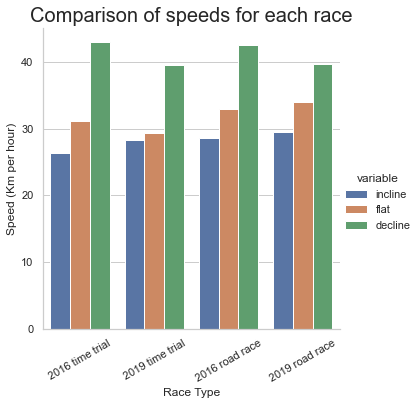

In [299]:
# plt.figure(figsize=(15,10))

sns.set_theme(style="whitegrid")


ax = sns.catplot(x = 'race_type', y='value', 
               hue = 'variable',data=elevationGainSpeeds, kind='bar')

# ax.set_xlabel('Race Type')
ax.set_xticklabels(rotation= 30)
plt.xlabel('Race Type')
plt.ylabel('Speed (Km per hour)')
plt.title('Comparison of speeds for each race', size=20)

plt.show()

We can now better see the improvements in each race. The 2016 road race had better speeds during decline, but the 2019 road race had better speeds on a flat and the incline. 

The 2016 time trial had better speeds during declines and flat but the 2019 had better speeds during the incline. 

Considering both 2019 races finished quicker, perhaps the improvement in speeds on the inclines and flats contributed to lowering the duration of the race. This would mean there is more instances where the rider is on a flat and incline compared to decline. 

In [300]:
summaryDF[['DF','timeTaken']]

,DF,timeTaken
0,tt16,0.739723
0,rr16,1.404073
0,tt19,0.737500
0,rr19,1.528611


# Challenge Question: Gear Usage

A modern race bike has up to 22 different gears with two chainrings on the front (attached to the pedals) and 10 or 11 at the back (attached to the wheel).   The ratio of the number of teeth on the front and rear cogs determines the distance travelled with one revolution of the pedals (often called __development__, measured in metres).  Low development is good for climbing hills while high development is for going fast downhill or in the final sprint. 

We have a measure of the number of rotations of the pedals per minute (__cadence__) and a measure of __speed__.  Using these two variables we should be able to derive a measure of __development__ which would effectivly tell us which gear the rider was using at the time.   Development will normally range between __2m__ and __10m__.  Due to errors in GPS and cadence measurements you will see many points outside this range and you should just discard them as outliers. 

Write code to calculate __development__ in _meters_ for each row in a ride.  Plot the result in a _histogram_ and compare the plots for the four rides.   Comment on what you observe in the histograms.

**Recall**: 

- development is bbetween 2m and 10m
- can use cadence and speed to determine develpment
- due to device errors, can discard outliers outside of this range
- cadence is measured in rpm and speed in kmph

### Determining Development

In [301]:
cadence = tt16_roll['cadence'].copy(deep= True)

In [302]:
len(cadence)

1541

In [303]:
cadence.describe()

count    1541.000000
mean       83.277093
std        21.169978
min         0.000000
25%        77.000000
50%        86.000000
75%        96.000000
max       118.000000
Name: cadence, dtype: float64

Converting kmph to metres per minute to match cadence's rpm 

In [304]:
speed = ((tt16_roll['speed'][tt16_roll['cadence'] > 0 ]/60)*1000).copy(deep=True)

$cadence = \frac{rotations}{minute}$
$speed = \frac{metres}{minute}$

we want $\frac{metres}{rotation}$

So speed / cadence gives 

$\frac{metres}{minute} \times \frac{minute}{rotations} = \frac{metres}{rotation}$

In [305]:
(speed / cadence)

0        0.000000
1        1.593266
2        1.157128
3        0.885781
4        0.926776
          ...    
1536     7.439148
1537     7.501954
1538          NaN
1539    11.334216
1540    10.553731
Length: 1541, dtype: float64

In [306]:
(speed / cadence).describe()

count    1479.000000
mean        6.272941
std         2.094033
min         0.000000
25%         5.026752
50%         6.081270
75%         7.143910
max        28.558467
dtype: float64

In [307]:
tt16_roll['dev'] = (speed / cadence)

You may notice there are instances where we get NAN values in the dev column. This is due to some values of cadence are zero, causing a division by zero. Since this calculation is not possible, it is replaced with NAN. We can check which instances are NANs to confirm it is indeed the rows where cadence = 0 

In [308]:
tt16_roll[tt16_roll['dev'].isna()][['cadence','dev']]

,cadence,dev
205,0.0,NaN
206,0.0,NaN
207,0.0,NaN
208,0.0,NaN
209,0.0,NaN
...,...,...
1276,0.0,NaN
1277,0.0,NaN
1278,0.0,NaN
1279,0.0,NaN


As per the question, finding the rows where the development is between 2 and 10 rotations per minute using the `.query()` function and applying it to the dataframe

In [309]:
devIndex= tt16_roll.query('2 <= dev <= 10').index

In [310]:
devIndex.shape

(1453,)

In [311]:
tt16_dev = tt16_roll.copy(deep= True)

In [312]:
tt16_dev = tt16_roll.iloc[devIndex]

In [313]:
tt16_dev.shape

(1453, 16)

In [314]:
tt16_dev['dev'].describe()

count    1453.000000
mean        6.149900
std         1.415715
min         2.135438
25%         5.027556
50%         6.071739
75%         7.119834
max         9.805810
Name: dev, dtype: float64

### Plotting development

Now let's plot this information. 

low gear = low dev because less meters travelled per metre. 

high gear = high dev because many meters travelled per metre. 

plotting on a histogram:

No handles with labels found to put in legend.


Text(0.5, 1.0, '2016 time trial development')

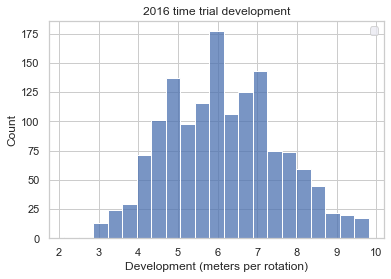

In [315]:
sns.histplot(tt16_dev['dev'], bins = 21)
sns.set(style="darkgrid")

# plt.show()
plt.xlabel('Development (meters per rotation)')
plt.ylabel('Count')
plt.legend()
plt.title('2016 time trial development')

Now performing the same process on the rest of the races. Putting everything in a function to easily call. 

In [316]:
def devFn(myDf):
    

    cadence = myDf['cadence'][myDf['cadence'] > 0 ].copy(deep= True)
    speed = ((myDf['speed'][myDf['cadence'] > 0 ]/60)*1000).copy(deep=True)
    myDf['dev'] = (speed / cadence)
    devIndex= myDf.query('2 <= dev <= 10').index
    myDf_dev = myDf.iloc[devIndex]
    
    return myDf_dev

In [317]:
rr16_dev = devFn(rr16_roll)

In [318]:
tt19_dev = devFn(tt19_roll)

In [319]:
rr19_dev = devFn(rr19_roll)

No handles with labels found to put in legend.


Text(0.5, 1.0, '2016 road race development')

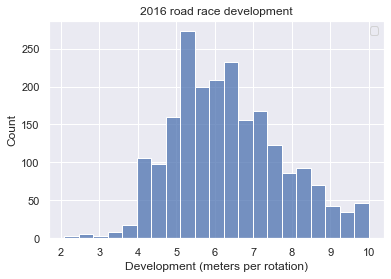

In [320]:
sns.histplot(rr16_dev['dev'], bins = 21)
sns.set(style="darkgrid")

# plt.show()
plt.xlabel('Development (meters per rotation)')
plt.ylabel('Count')
plt.legend()
plt.title('2016 road race development')

No handles with labels found to put in legend.


Text(0.5, 1.0, '2019 road race development')

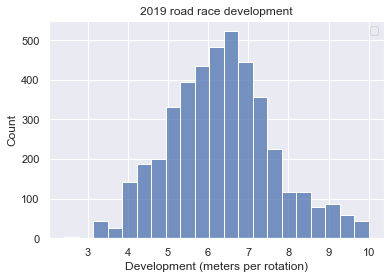

In [321]:
sns.histplot(rr19_dev['dev'], bins = 21)
sns.set(style="darkgrid")

# plt.show()
plt.xlabel('Development (meters per rotation)')
plt.ylabel('Count')
plt.legend()
plt.title('2019 road race development')

No handles with labels found to put in legend.


Text(0.5, 1.0, '2019 time trial development')

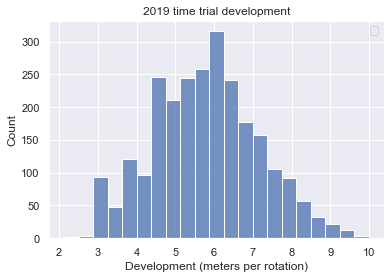

In [322]:
sns.histplot(tt19_dev['dev'], bins = 21)
sns.set(style="darkgrid")

# plt.show()
plt.xlabel('Development (meters per rotation)')
plt.ylabel('Count')
plt.legend()
plt.title('2019 time trial development')

Plotting the races together

Text(0.5, 1.0, 'Comparing the development in all races')

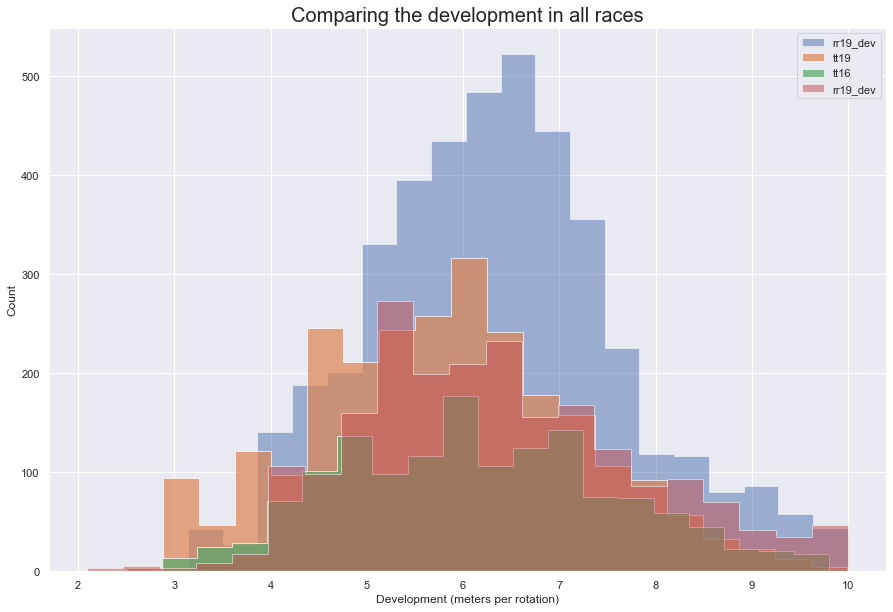

In [323]:
plt.figure(figsize=(15,10))

# sns.histplot(data=[tt16_dev['dev'], tt19_dev['dev']],color=['r','b'], bins = 21)

rr19_dev['dev'].hist(histtype = 'stepfilled',alpha = .5, bins = 21, label='rr19_dev')
tt19_dev['dev'].hist(histtype = 'stepfilled',alpha = .7, bins = 21, label='tt19')
tt16_dev['dev'].hist(histtype = 'stepfilled',alpha = .7, bins = 21, label='tt16')
rr16_dev['dev'].hist(histtype = 'stepfilled',alpha = .5, bins = 21, label='rr19_dev')

sns.set(style="darkgrid")

# plt.show()
plt.xlabel('Development (meters per rotation)')
plt.ylabel('Count')
plt.legend()
plt.title('Comparing the development in all races', size = 20)

This is a bit difficult to visualise, so let's reduce the number and compare by type of race. 

Text(0.5, 1.0, 'Comparing the development in time trials')

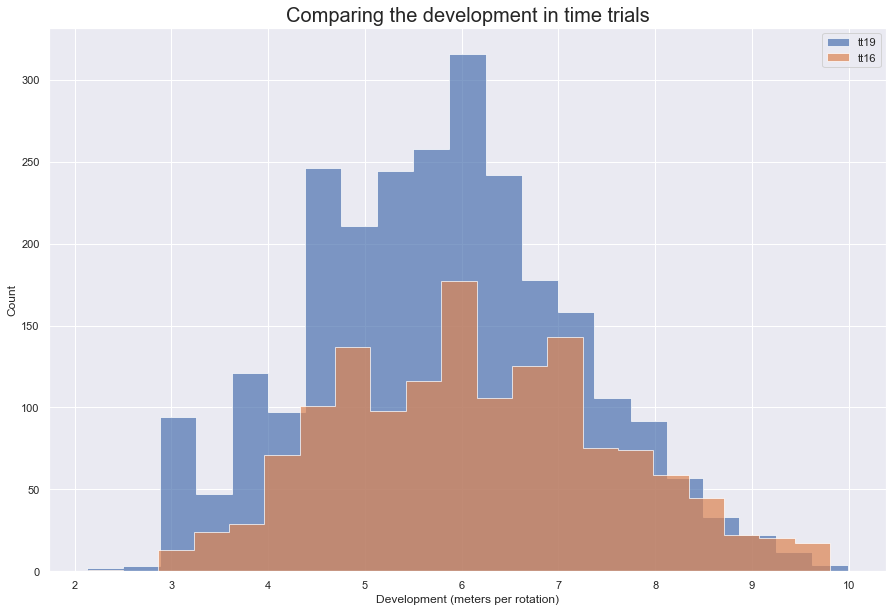

In [324]:
plt.figure(figsize=(15,10))

# sns.histplot(data=[tt16_dev['dev'], tt19_dev['dev']],color=['r','b'], bins = 21)

# sns.histplot(tt19_dev['dev'], color='red',bins = 21, label = 'tt19', alpha = 0.5)
# sns.histplot(tt16_dev['dev'], color='blue', bins = 21 , label = 'tt16', alpha = 0.5)
# rr19_dev['dev'].hist(histtype = 'stepfilled',alpha = .5, bins = 21, label='rr19_dev')
tt19_dev['dev'].hist(histtype = 'stepfilled',alpha = .7, bins = 21, label='tt19')
tt16_dev['dev'].hist(histtype = 'stepfilled',alpha = .7, bins = 21, label='tt16')
# rr16_dev['dev'].hist(histtype = 'stepfilled',alpha = .5, bins = 21, label='rr19_dev')

sns.set(style="darkgrid")

# plt.show()
plt.xlabel('Development (meters per rotation)')
plt.ylabel('Count')
plt.legend()
plt.title('Comparing the development in time trials', size = 20)

Text(0.5, 1.0, 'Comparing the development in road races')

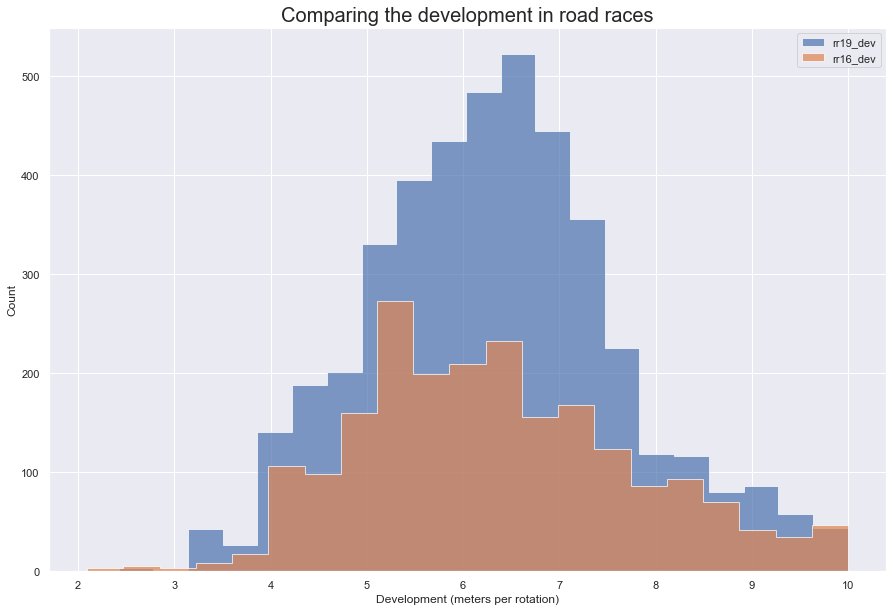

In [325]:
plt.figure(figsize=(15,10))

# sns.histplot(data=[tt16_dev['dev'], tt19_dev['dev']],color=['r','b'], bins = 21)

# sns.histplot(tt19_dev['dev'], color='red',bins = 21, label = 'tt19', alpha = 0.5)
# sns.histplot(tt16_dev['dev'], color='blue', bins = 21 , label = 'tt16', alpha = 0.5)
rr19_dev['dev'].hist(histtype = 'stepfilled',alpha = .7, bins = 21, label='rr19_dev')
# tt19_dev['dev'].hist(histtype = 'stepfilled',alpha = .7, bins = 21, label='tt19')
# tt16_dev['dev'].hist(histtype = 'stepfilled',alpha = .7, bins = 21, label='tt16')
rr16_dev['dev'].hist(histtype = 'stepfilled',alpha = .7, bins = 21, label='rr16_dev')

sns.set(style="darkgrid")

# plt.show()
plt.xlabel('Development (meters per rotation)')
plt.ylabel('Count')
plt.legend()
plt.title('Comparing the development in road races', size = 20)

the 2019 road race has had the most counts overall. Perhaps due to the size of the DF being signifiicantly larger than the other DFs?  

We can further improve the visualisation by making subplots:

Help with subplots from https://dev.to/thalesbruno/subplotting-with-matplotlib-and-seaborn-5ei8

Text(0.5, 1.0, 'Road Races')

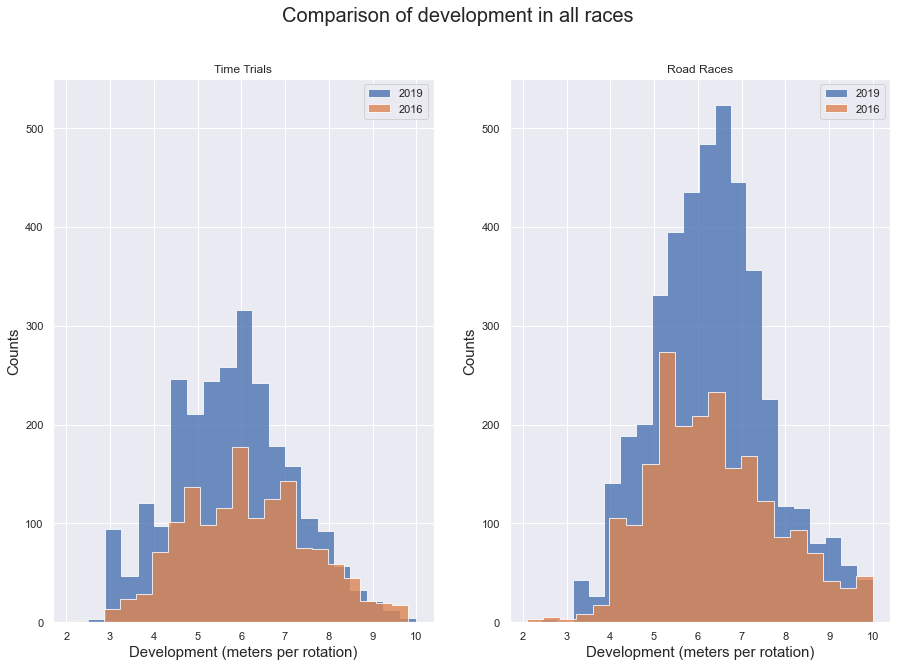

In [326]:


fig, axes= plt.subplots(1,2, figsize=(15,10), sharex= True)



tt19_dev['dev'].hist(histtype = 'stepfilled',alpha = .8, bins = 21, label='2019', ax=axes[0])
tt16_dev['dev'].hist(histtype = 'stepfilled',alpha = .8, bins = 21, label='2016', ax=axes[0])

rr19_dev['dev'].hist(histtype = 'stepfilled',alpha = .8, bins = 21, label='2019', ax=axes[1])
rr16_dev['dev'].hist(histtype = 'stepfilled',alpha = .8, bins = 21, label='2016',ax= axes[1])

axes[0].legend(loc='best')
axes[1].legend(loc='best')

axes[0].set_ylim(0,550)
axes[1].set_ylim(0,550)

axes[0].set_ylabel('Counts', size=15)
axes[1].set_ylabel('Counts', size=15)

axes[0].set_xlabel('Development (meters per rotation)', size=15)
axes[1].set_xlabel('Development (meters per rotation)', size=15)

fig.suptitle('Comparison of development in all races', size=20)
axes[0].set_title('Time Trials')
axes[1].set_title('Road Races')

We can now see more clearly the differences in development between the races and the years. It should be noted that the counts for both road races are higher than the time trials due to the number of rows that exist being higher in the respective dataframes. More rows means there are more counts, thus the higher number the plot will be. In conclusion, I believe this is a poor comparison to make due to this discrepancy. If the number of rows were similar, we could have a better understanding of the development between the years and races. The rows are different due to the observations the recording device had made throughout each race. The observations are not separated evenly thus causing the different number of counts we see here. 

In [327]:
rr19_dev.shape

(4301, 14)

In [328]:
rr16_dev.shape

(2134, 15)

In [329]:
tt19_dev.shape

(2543, 17)

In [330]:
tt16_dev.shape

(1453, 16)

### Trying to apply a model (extra work / for fun)

Help from w5 notebook. 

- What do we want to predict?
- What would be useful to predict?
- What features do we want to use in the model? 



Information on R$^2$ meaning: https://gist.github.com/ravy101/faddbd1a0c207ef3ef2afee9252c5761


Using the development and elevation gain status, the model can determine the speed of the rider with accuracy of 88% and an error of ±3.41kmph. Note the dataset has not been split up 

We are required to split the dataset into a training and test set. If we just have a training set (no splitting) then the model may overfit the data. 

In [331]:
train, test = train_test_split(tt16_dev, test_size=0.2, random_state=1)
print(train.shape)
print(test.shape)

(1162, 16)
(291, 16)


Choosing the features `elevation_gain` and `distance_cumsum` as these are independent variables throughout the race. We will be able to use these to determine what development (or gear) we should be in at certain moments in the race. 

In [332]:
reg = linear_model.LinearRegression()
features = ['elevation_gain','distance_cumsum']
Xtrain = train[features]
yTrain = train['dev']
reg.fit(Xtrain, yTrain)
print("y = x *", reg.coef_, "+", reg.intercept_)

y = x * [-2.51286499  0.01460157] + 6.088696166605707


In [333]:
predicted = reg.predict(Xtrain)
mse = ((np.array(yTrain)-predicted)**2).sum()/len(yTrain)
r2 = r2_score(yTrain, predicted)
print("MSE:", mse)
print("R Squared:", r2)

MSE: 1.087015525023382
R Squared: 0.46057261618077083


In [334]:
Xtest= test[features]
yTest = test['dev']

In [335]:
predicted = reg.predict(Xtest)
mse = ((np.array(yTest)-predicted)**2).sum()/len(yTest)
r2 = r2_score(yTest, predicted)
print("MSE:", mse)
print("R Squared:", r2)

MSE: 0.9915237710265802
R Squared: 0.49054667288092035


The linear regression model explains 49% of the variance in the predicted developments. This model only used two predictors (features) being `elevation_gain` and `distance_cumsum`. Checking how this compares to the mean of the data, we can see how the mean only accounts for about 10% of the data variance. Using the model is a significant improvement to using the mean to describe the variance in the data. 

In [354]:
y = tt16_dev['dev']
squareDeviations = (y - y.mean())**2
totalSquareSum = squareDeviations.sum()
totalSquareSum

2910.1703650941745

In [355]:
errors= yTest - predicted
errorSquare = errors**2
residualSum = errorSquare.sum()
residualSum

288.53341736873483

In [357]:
explainedResiduals = totalSquareSum - residualSum
r2 = 1 - explainedResiduals/totalSquareSum
r2

0.09914657259572424

The plot shows the required gear for the specified elevation gear. The model has fitted as the data as accurately as it can with the given features. The direction of the model is also correct, as we go on an incline, we want to decrease the development.  

Text(0.5, 1.0, 'Predicting the development throughout a race')

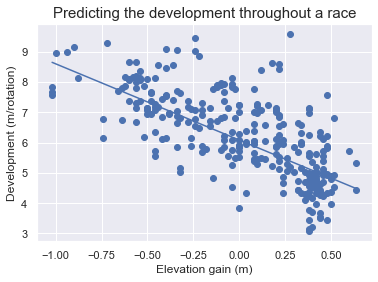

In [363]:
xMin = Xtest['elevation_gain'].min()
xMax = Xtest['elevation_gain'].max()

yMin = xMin*reg.coef_[0] + reg.intercept_
yMax = xMax*reg.coef_[0] + reg.intercept_

plt.plot([xMin, xMax], [yMin, yMax])
plt.scatter(Xtest['elevation_gain'], yTest)
plt.xlabel('Elevation gain (m)')
plt.ylabel('Development (m/rotation)')
plt.title('Predicting the development throughout a race',size=15
    )